In [21]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu

# Load the CSV file
dryadDir = 'C:/code/miniscope-analysis-mek/InterneuronInhibNAc/InterneuronInhibNAc/dryad/'
file_path = dryadDir + "/gria_sequencing.csv"  
figDataSaveDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data"


df = pd.read_csv(file_path)
clustering_mapping = {
    'Drd1Pdyn': 'MSNs',
    'Drd2Penk': 'MSNs',
    'Drd1Penk': 'MSNs',
    'Drd1PdynOprm1': 'MSNs',
    'Drd2NoPenk': 'MSNs',
    'CholinergicInterneurons': 'Other',
    'PvalbInterneurons': 'PV Ints',
    'SstNpyInterneurons': 'SST+NPY Ints',
    'Astrocytes': 'Glia',
    'MatureOligos': 'Glia',
    'Microglia': 'Glia',
    'ImmatureOligos': 'Glia',
    'GABAergicNeurons': 'Other',
    'Dlx2ImmatureNeurons': 'Other'
}


# Exclude 'RadialGlia-LikeCells'
df = df[df['mostafa_clusts'] != 'RadialGlia-LikeCells']
# Apply the mapping to create the new_clustering column
df['mostafa_clusts'] = df['mostafa_clusts'].map(clustering_mapping)

# Find rows where the 'new_clustering' column is NaN
nan_rows = df[df['mostafa_clusts'].isna()]

# Print unique values in the 'mostafa_clusts' column that are not in the mapping
unique_unmapped = nan_rows['mostafa_clusts'].unique()
print("\nUnique values in 'mostafa_clusts' that are not in the mapping:")
print(unique_unmapped)

# Convert 'mostafa_clusts' column to string to avoid any type issues
df['mostafa_clusts'] = df['mostafa_clusts'].astype(str)

# Print the unique values in the new clustering column to verify
print("Unique values in the new clustering column:")
print(df['mostafa_clusts'].unique())


Unique values in 'mostafa_clusts' that are not in the mapping:
[]
Unique values in the new clustering column:
['MSNs' 'Glia' 'Other' 'SST+NPY Ints' 'PV Ints']



Number of cells in each cluster:
mostafa_clusts
MSNs            64256
Glia             9804
Other            6645
PV Ints          2434
SST+NPY Ints      726
Name: count, dtype: int64

Total number of cells: 83865

ANOVA results:
                         sum_sq       df            F  PR(>F)
C(mostafa_clusts)   7673.231785      4.0  3164.013122     0.0
Residual           50843.437807  83860.0          NaN     NaN

Post-hoc Tukey's HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2    meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
   Glia         MSNs    0.693    0.0  0.6699   0.716   True
   Glia        Other   0.0172 0.6326 -0.0165   0.051  False
   Glia      PV Ints  -0.2021    0.0 -0.2502  -0.154   True
   Glia SST+NPY Ints   0.0581 0.2958 -0.0236  0.1398  False
   MSNs        Other  -0.6757    0.0 -0.7031 -0.6484   True
   MSNs      PV Ints  -0.8951    0.0 -0.9389 -0.8512   True
   MSNs SST+

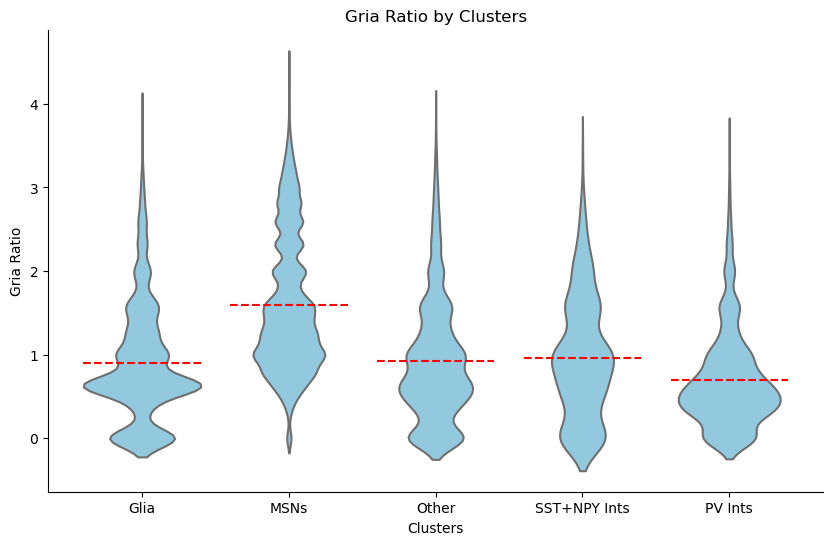


Pairwise comparisons (PV Ints vs others):
PV Ints vs Glia: U = 9532595.50, p = 1.562e-54, corrected p = 6.249e-54
PV Ints vs MSNs: U = 25356023.50, p = 1.000e-300, corrected p = 4.000e-300
PV Ints vs Other: U = 6576168.00, p = 5.229e-43, corrected p = 2.092e-42
PV Ints vs SST+NPY Ints: U = 682344.00, p = 4.281e-21, corrected p = 1.712e-20
Cell data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/other\cell_data.csv


In [23]:
# Remove rows with NaN or inf values in 'gria_ratio' or 'gria2'
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['gria_ratio', 'gria2'], inplace=True)

# Calculate RPKM for gria2 using a gene length of 883 base pairs (0.883 kb)
gria2_length_kb = 0.883

def calculate_gria2_rpkm(row):
    reads_mapped = row['gria2']
    total_reads = row['nCount_RNA']
    rpkm = (reads_mapped / ((gria2_length_kb / 1000) * (total_reads / 1_000_000)))
    return rpkm

# Apply the RPKM calculation and add it as a new column
df['gria2_RPKM'] = df.apply(calculate_gria2_rpkm, axis=1)

# Print out the number of cells in each cluster and the total number
cluster_counts = df['mostafa_clusts'].value_counts()
total_cells = len(df)
print("\nNumber of cells in each cluster:")
print(cluster_counts)
print(f"\nTotal number of cells: {total_cells}")

# Calculate means for 'gria_ratio' and ensure PV Ints is last
gria_ratio_means = df.groupby('mostafa_clusts')['gria_ratio'].mean()
cluster_order = [c for c in gria_ratio_means.index if c != 'PV Ints'] + ['PV Ints']

# Create the first violin plot (gria_ratio by 'mostafa_clusts')
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='mostafa_clusts', 
    y='gria_ratio', 
    data=df, 
    inner=None, 
    color="skyblue", 
    order=cluster_order
)

# Add horizontal lines for cluster means
for i, cluster in enumerate(cluster_order):
    plt.hlines(
        gria_ratio_means[cluster], 
        i - 0.4, 
        i + 0.4, 
        colors='red', 
        linestyles='--', 
        linewidth=1.5
    )

plt.title('Gria Ratio by Clusters')
plt.ylabel('Gria Ratio')
plt.xlabel('Clusters')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Omnibus test using ANOVA
anova_model = ols('gria_ratio ~ C(mostafa_clusts)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("\nANOVA results:")
print(anova_table)

# Post-hoc test using Tukey's HSD
tukey = pairwise_tukeyhsd(df['gria_ratio'], df['mostafa_clusts'])
print("\nPost-hoc Tukey's HSD results:")
print(tukey)

plt.savefig(os.path.join(figDataSaveDir + '/other', 'gria_ratio_by_clusters.svg'), format='svg')
plt.savefig(os.path.join(figDataSaveDir + '/other', 'gria_ratio_by_clusters.png'), format='png')
plt.show()

# Pairwise comparisons for PV Ints
pv_ints_ratios = df[df['mostafa_clusts'] == 'PV Ints']['gria_ratio']
pairwise_results = {}
for cluster in cluster_order:
    if cluster != 'PV Ints':
        cluster_ratios = df[df['mostafa_clusts'] == cluster]['gria_ratio']
        stat, p_value = mannwhitneyu(pv_ints_ratios, cluster_ratios, alternative='less')
        # Replace exact zero p-values with a very small number
        p_value = max(p_value, 1e-300)
        pairwise_results[cluster] = {'stat': stat, 'p-value': p_value}

# Correct for multiple comparisons
p_values = [result['p-value'] for result in pairwise_results.values()]
_, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# Add corrected p-values to results
for cluster, corrected_p in zip(pairwise_results.keys(), corrected_p_values):
    pairwise_results[cluster]['corrected_p-value'] = corrected_p

# Print pairwise comparison results
print("\nPairwise comparisons (PV Ints vs others):")
for cluster, result in pairwise_results.items():
    print(f"PV Ints vs {cluster}: U = {result['stat']:.2f}, p = {result['p-value']:.3e}, corrected p = {result['corrected_p-value']:.3e}")

# Save the actual data for each cell to a CSV file
cell_data_path = os.path.join(figDataSaveDir + '/other', 'cell_data.csv')
df.to_csv(cell_data_path, index=False)
print(f"Cell data saved to {cell_data_path}")

